# Домашнее задание 6

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите какой результат вы получили? Что помогло вам улучшить ее точность?

## Импорт

In [1]:
!pip install stop-words pymorphy2

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=e67cf11376dbbe32e4f8ea4831bb1f93e936dcf54770cd4cda645cf7a26c703d
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=d1aaf65e96cb80a8196c1a5a1f9c03ccf42263aae344c787c45f5f2d754218ee
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built stop-words docopt


In [2]:
#предобработка
from string import punctuation
#from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
max_words = 2000
max_len = 20
num_classes = 1

# обучение
epochs = 10
batch_size = 512
print_batch_n = 100

## Загрузка данных

In [4]:
# пути к данным
dataset_train  = '/content/drive/MyDrive/Colab Notebooks/train.csv'
dataset_test  = '/content/drive/MyDrive/Colab Notebooks/test.csv'

In [5]:
#загрузка данных
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')

In [6]:
#тренировочный датасет
data_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [7]:
#тестовый датасет
data_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."


In [8]:
#разделение тренировочного датасета на обучающий и валидационный
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=42)

In [9]:
#датасет для обучения модели
df_train.head()

,id,text,class
152276,152276,"Вот капец. @xam_vz вышел, а я его ещё ни разу ...",0
3026,3026,"проснулась пораньше, чтобы хоть немного подгот...",1
129883,129883,Мамка сегодня спонтанна купила мне киндер сюрп...,1
103260,103260,"@iKurash1 Неприятно будет, если выяснится, что...",0
1592,1592,"RT @IRkIN163rus: Почему нам нравятся люди, кот...",0


In [10]:
df_train['class'].value_counts()

1    64260
0    62766
Name: class, dtype: int64

In [11]:
#датасет для валидации модели
df_valid.head()

,id,text,class
133370,133370,@ArtMayers Я думала туса интересная))) а то на...,1
84601,84601,"рядом дышии, и не будем мы грустить заяя...\nп...",1
78178,78178,вот че она ржет надо мной=( http://t.co/dGP8la...,0
49055,49055,А мы и сообщения не пишем:( #жизньболь http://...,0
159239,159239,@Horan_69_ID иди полежи или таблетку выпей(,0


In [12]:
df_valid['class'].value_counts()

1    27803
0    26638
Name: class, dtype: int64

## Предобработка данных

In [13]:
from stop_words import get_stop_words

In [14]:
#множество стоп-слов
sw = set(get_stop_words("ru"))
print(sw)

{'сеаой', 'сначала', 'нам', 'или', 'девятнадцать', 'какая', 'будут', 'посреди', 'ими', 'чем', 'мною', 'всего', 'дальше', 'одной', 'про', 'тому', 'иметь', 'тех', 'этих', 'тебе', 'четыре', 'этом', 'под', 'рядом', 'через', 'буду', 'раньше', 'сами', 'семнадцатый', 'оно', 'кому', 'хотя', 'была', 'день', 'туда', 'одного', 'почти', 'не', 'оба', 'тебя', 'те', 'самим', 'начала', 'никогда', 'сказать', 'нас', 'меля', 'пять', 'да', 'нами', 'время', 'себя', 'год', 'вот', 'твой', 'были', 'будете', 'четвертый', 'ту', 'мне', 'чего', 'семнадцать', 'них', 'сам', 'этому', 'человек', 'шестнадцать', 'другое', 'перед', 'один', 'мной', 'к', 'стал', 'два', 'нем', 'позже', 'ты', 'всему', 'ж', 'мог', 'другие', 'наконец', 'если', 'давно', 'теперь', 'говорил', 'двадцать', 'мои', 'мой', 'всех', 'конечно', 'одиннадцатый', 'нет', 'занято', 'будто', 'впрочем', 'уметь', 'меня', 'пора', 'сама', 'просто', 'никуда', 'сколько', 'а', 'моё', 'потому', 'с', 'немного', 'многочисленное', 'ниже', 'раз', 'у', 'сейчас', 'своей', 

In [15]:
#пунктуация
exclude = set(punctuation)
print(exclude)

{'&', '_', '?', '}', '/', '{', '~', '\\', '!', '(', "'", '<', '*', '#', '`', '^', '.', '|', '-', ']', '$', ',', '+', '[', '%', ')', ';', '=', '>', ':', '@', '"'}


In [16]:
morpher = MorphAnalyzer()

In [17]:
#функция преобразования текста
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [18]:
#преобразование текста в данных
from tqdm import tqdm
tqdm.pandas()

In [19]:
df_train['text'] = df_train['text'].apply(preprocess_text)
df_valid['text'] = df_valid['text'].apply(preprocess_text)
data_test['text'] = data_test['text'].apply(preprocess_text)

In [20]:
#соединение всех обучающих данных в одну строку и приведение к нижнему регистру
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [21]:
#токенезация (разбиваем строку на слова)
tokens = word_tokenize(train_corpus)
tokens[:10]

['капец',
 'xamvz',
 'выйти',
 'разуна',
 'видеть',
 'времявремя',
 'взять',
 'проснуться',
 'ранний',
 'хотьнемного']

In [22]:
#отфильтруем токены (проверяем, чтобы все символы были или буквы или цифры)
tokens_filtered = [word for word in tokens if word.isalnum()]

In [23]:
#частотное распределение: как часто встречается каждый токен в tokens_filtered
dist = FreqDist(tokens_filtered)
dist

FreqDist({'rt': 21279, 'd': 5908, 'хотеть': 5814, 'знать': 3485, 'ян': 2990, 'мочь': 2960, 'любить': 2856, 'новый': 2842, 'завтра': 2781, 'мой': 2551, ...})

In [24]:
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [25]:
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999,
 ['rt',
  'd',
  'хотеть',
  'знать',
  'ян',
  'мочь',
  'любить',
  'новый',
  'завтра',
  'мой'])

In [26]:
#словарь слово : индекс из tokens_filtered_top
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top)).items()}
vocabulary

{'rt': 0,
 'd': 1,
 'хотеть': 2,
 'знать': 3,
 'ян': 4,
 'мочь': 5,
 'любить': 6,
 'новый': 7,
 'завтра': 8,
 'мой': 9,
 'хороший': 10,
 'делать': 11,
 'смотреть': 12,
 'день': 13,
 'вообще': 14,
 'думать': 15,
 'идти': 16,
 'блин': 17,
 'иня': 18,
 'самый': 19,
 'спать': 20,
 'сидеть': 21,
 'дом': 22,
 'пойти': 23,
 '3': 24,
 'утро': 25,
 'писать': 26,
 'один': 27,
 'друг': 28,
 'сделать': 29,
 'школа': 30,
 'ждать': 31,
 '2': 32,
 'человек': 33,
 'настроение': 34,
 'такой': 35,
 'час': 36,
 'мама': 37,
 'любимый': 38,
 'хотеться': 39,
 'написать': 40,
 'говорить': 41,
 'болеть': 42,
 'видеть': 43,
 'работа': 44,
 'последний': 45,
 'прийти': 46,
 'свой': 47,
 'посмотреть': 48,
 'добрый': 49,
 'ночь': 50,
 'понять': 51,
 'купить': 52,
 'какой': 53,
 'найти': 54,
 'нравиться': 55,
 'понимать': 56,
 'скоро': 57,
 'вчера': 58,
 'скучать': 59,
 'чтоть': 60,
 'читать': 61,
 'забыть': 62,
 'стать': 63,
 'остаться': 64,
 'дело': 65,
 'давать': 66,
 'первый': 67,
 'урок': 68,
 'фильм': 69,
 'р

In [27]:
#преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())  #токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()] #фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) #если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) #нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [28]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["text"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["text"]])

x_train.shape, x_valid.shape, x_test.shape

((127026, 20), (54441, 20), (22684, 20))

In [29]:
#данные после подготовки к обучению
torch.from_numpy(x_train[0])

tensor([ 326,  130, 1596,   43,  132,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

## Построение и обучение модели

In [30]:
#Датасет
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() #преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long() #преобразуем в целочисленный тензор
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]  #индексация данных
        y = self.target[index]  #индексация целевой переменной

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [33]:
#создание представителей классов Dataset и Dataloader
train_dataset = DataWrapper(x_train, df_train['class'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['class'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [34]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 20]) tensor([677, 363, 677, 243,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0])
torch.Size([512]) tensor(1)


In [35]:
#сверточная нейронная сеть
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)

    def forward(self, x):
        output = self.embedding(x) # B, L, E
        #                       B  E  L
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [37]:
#инициализация модели
model = Net(vocab_size=max_words)
print(model)

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)


In [38]:
#компиляция модели
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [39]:
#обучение модели
model.train()
th = 0.5

train_loss_history = []
valid_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обучение
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)

        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 150 batches
            model.eval()

            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на тестовых данных
            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(valid_loader):
                test_labels = data[1]
                test_outputs = model(data[0])

                # подсчет ошибки на тесте
                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                test_running_total += len(data[1])
                pred_test_labels = torch.squeeze((test_outputs > th).int())
                test_running_right += (test_labels == pred_test_labels).sum()

            valid_loss_history.append(test_loss.item())
            print(f'Val loss: {test_loss:.3f}. Val acc: {test_running_right / test_running_total:.3f}')

        model.train()

print('Training is finished!')

Epoch [1/10]. Step [1/249]. Loss: 0.697. Acc: 0.480. Val loss: 0.706. Val acc: 0.489
Epoch [1/10]. Step [151/249]. Loss: 0.619. Acc: 0.616. Val loss: 0.327. Val acc: 0.658
Epoch [2/10]. Step [1/249]. Loss: 0.533. Acc: 0.723. Val loss: 0.804. Val acc: 0.680
Epoch [2/10]. Step [151/249]. Loss: 0.530. Acc: 0.704. Val loss: 0.444. Val acc: 0.692
Epoch [3/10]. Step [1/249]. Loss: 0.529. Acc: 0.744. Val loss: 0.576. Val acc: 0.690
Epoch [3/10]. Step [151/249]. Loss: 0.534. Acc: 0.727. Val loss: 0.808. Val acc: 0.695
Epoch [4/10]. Step [1/249]. Loss: 0.420. Acc: 0.824. Val loss: 0.091. Val acc: 0.694
Epoch [4/10]. Step [151/249]. Loss: 0.501. Acc: 0.741. Val loss: 0.218. Val acc: 0.698
Epoch [5/10]. Step [1/249]. Loss: 0.461. Acc: 0.777. Val loss: 0.280. Val acc: 0.696
Epoch [5/10]. Step [151/249]. Loss: 0.477. Acc: 0.757. Val loss: 0.133. Val acc: 0.690
Epoch [6/10]. Step [1/249]. Loss: 0.427. Acc: 0.787. Val loss: 0.867. Val acc: 0.694
Epoch [6/10]. Step [151/249]. Loss: 0.502. Acc: 0.773. 

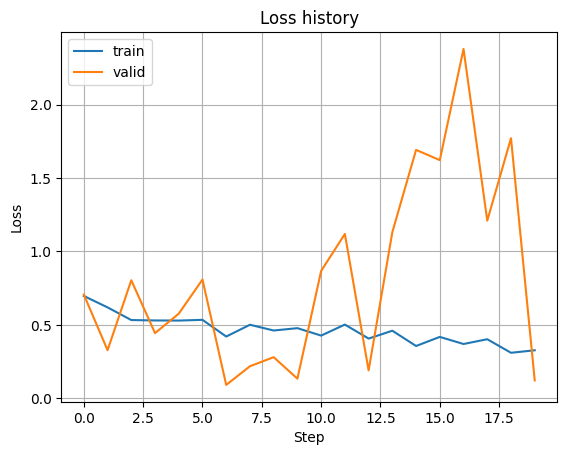

In [40]:
#визуализации функции потерь
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

In [41]:
#тестирование модели
input = torch.from_numpy(x_test).long()
test_outputs = model(input)
outputs_label = np.where(test_outputs > 0.5, 1, 0)
test_outputs, outputs_label

(tensor([[0.0543],
         [0.0922],
         [0.7528],
         ...,
         [0.2841],
         [0.0092],
         [0.1650]], grad_fn=<SigmoidBackward0>),
 array([[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]]))